In [99]:
from read_alignment import readAlignment
import helperFxns_new as kim_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import seaborn as sns


In [100]:
def rewrite_header_fasta(input_fasta, output_fasta):
    with open(output_fasta, "w") as out_f:
        for i, record in enumerate(SeqIO.parse(input_fasta, "fasta"), start=1):
            record.id = f"seq{i}"
            record.description = ""  # Remove any additional description
            SeqIO.write(record, out_f, "fasta")

    print("Headers updated successfully!")



def clean_fasta(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        fasta_dict = {}
        header = None
        for line in infile:
            line = line.strip()  # Remove leading/trailing whitespace (including erroneous newlines)
            if line.startswith(">"):  # New header
                header = line
                fasta_dict[header] = []
            elif header:  # Sequence line
                fasta_dict[header].append(line)

        # Write cleaned FASTA
        for header, seq_list in fasta_dict.items():
            outfile.write(f"{header}\n{''.join(seq_list)}\n")  # Concatenated sequence in one line

def compute_avg_seq_identity(smat):
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    return avg_identity


def plot_avg_seq_identity_histogram(smat, bins=50):
    """ Given a sequence identity matrix, plot a histogram of the average pairwise sequence identity for each sequence. """
    num_sequences = smat.shape[0]

    # Compute the average pairwise identity for each sequence
    # sum up each row (i.e. along the columns), subtract from self-comparison, divide by total # of sequences
    avg_identity = (smat.sum(axis=1) - np.diag(smat)) / (num_sequences - 1)

    # Plot histogram
    plt.figure(figsize=(8,6))
    plt.hist(avg_identity, bins=bins, density=True, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("Average Pairwise Sequence Identity")
    plt.ylabel("Density")
    plt.title("Histogram of Average Pairwise Sequence Identity")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


In [101]:
arr_seq = readAlignment('data/cleaned_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)


len of sequences: 970
arr_num shape: (970, 2767)
seq shape before filtering: (970, 2767)
seq shape after filtering: (752, 437)


In [102]:
# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_real = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_real.shape)

one hot after filtering: (752, 9177)
identity shape: (752, 752)


In [103]:
# print(one_hot_filtered)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


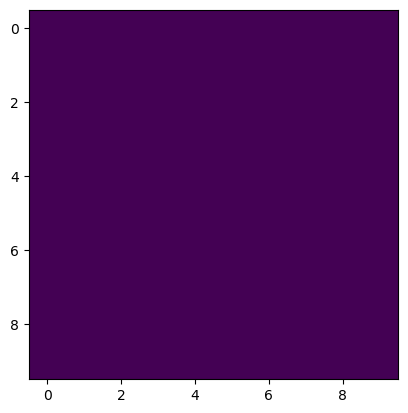

In [104]:

def compute_lxl_cov(one_hot_matrix, L):
    """
    Computes an L x L covariance matrix from a one-hot encoded matrix.
    
    Parameters:
    one_hot_matrix : numpy array of shape (20*L, M)
        One-hot encoded representation of M amino acid sequences of length L.
    L : int
        Sequence length.
    
    Returns:
    C_lxl : numpy array of shape (L, L)
        L x L covariance matrix capturing positional correlations.
    """
    M = one_hot_matrix.shape[1]  # Number of sequences
    
    # Compute empirical frequency matrix
    P = (one_hot_matrix @ one_hot_matrix.T) / M
    
    # Compute mean frequency
    p = np.mean(one_hot_matrix, axis=1, keepdims=True)
    
    # Compute covariance matrix
    C = P - p @ p.T
    
    # Reshape into L x L blocks of size 20x20
    C_lxl = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C_block = C[i*21:(i+1)*21, j*21:(j+1)*21]
            C_lxl[i, j] = np.linalg.norm(C_block, ord='fro')  # Frobenius norm
            # cov_mat = np.cov(C_block)  # Frobenius norm
            # print(np.mean(cov_mat))
            # C_lxl[i, j] = np.mean(cov_mat)  # Frobenius norm

    return C_lxl

# Example usage
L = 10  # Sequence length
M = 100  # Number of sequences
np.random.seed(42)
one_hot_matrix = np.ones((20*L, M))
#one_hot_matrix = np.random.randint(0, 2, size=(20*L, M))  # Simulated one-hot encoding
C_lxl = compute_lxl_cov(one_hot_matrix, L)
print(C_lxl)
plt.imshow(C_lxl)

(200, 30)
(200, 200)
[[369.4 329.6 333.5 329.5 353.  361.4 364.9 311.9 356.8 159.8]
 [329.6 318.8 307.9 304.9 321.  332.6 336.  291.6 323.2 147.6]
 [333.5 307.9 323.4 308.6 331.  335.8 338.8 294.6 329.5 145.3]
 [329.5 304.9 308.6 311.  321.9 329.4 335.4 288.4 322.5 143.6]
 [353.  321.  331.  321.9 359.9 353.2 363.2 305.4 351.9 156.7]
 [361.4 332.6 335.8 329.4 353.2 371.  363.6 313.1 354.4 158.4]
 [364.9 336.  338.8 335.4 363.2 363.6 387.7 317.8 363.6 166.6]
 [311.9 291.6 294.6 288.4 305.4 313.1 317.8 288.5 311.5 140.8]
 [356.8 323.2 329.5 322.5 351.9 354.4 363.6 311.5 364.  160.5]
 [159.8 147.6 145.3 143.6 156.7 158.4 166.6 140.8 160.5  81.7]]


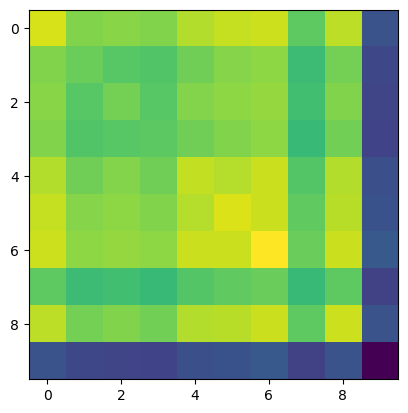

In [105]:

def compute_lxl_cov(one_hot_matrix, L):
    """
    Computes an L x L covariance matrix from a one-hot encoded matrix.
    
    Parameters:
    one_hot_matrix : numpy array of shape (20*L, M)
        One-hot encoded representation of M amino acid sequences of length L.
    L : int
        Sequence length.
    
    Returns:
    C_lxl : numpy array of shape (L, L)
        L x L covariance matrix capturing positional correlations.
    """
    M = one_hot_matrix.shape[1]  # Number of sequences
    
    # Compute empirical frequency matrix
    #S = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    #print(S.shape)

    C = (1/L)*(one_hot_matrix @ one_hot_matrix.T)
    print(C.shape)
    
    # Compute mean frequency
    #p = np.mean(one_hot_matrix, axis=1, keepdims=True)
    # print(p.shape)
    
    # Compute covariance matrix
    #C = P - p @ p.T
    
    # Reshape into L x L blocks of size 20x20
    C_lxl = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            C_block = C[i*21:(i+1)*21, j*21:(j+1)*21]
            #print('c block;:', C_block)
            #print('I:', i, 'J:', j, 'cov:', np.sum(C_block))
            C_lxl[i, j] = np.sum(C_block)  # Frobenius norm
            # C_lxl[i, j] = np.linalg.norm(C_block, ord='fro')
            # cov_mat = np.cov(C_block)  # Frobenius norm
            # print(np.mean(cov_mat))
            # C_lxl[i, j] = np.mean(cov_mat)  # Frobenius norm

    return C_lxl

# Example usage
L = 10  # Sequence length
M = 30  # Number of sequences
np.random.seed(42)
#one_hot_matrix = np.ones((21*L, M))
one_hot_matrix = np.random.randint(0, 2, size=(20*L, M))  # Simulated one-hot encoding
print(one_hot_matrix.shape)
C_lxl = compute_lxl_cov(one_hot_matrix, L)
print(C_lxl)
plt.imshow(C_lxl)

In [106]:
print('one hot after filtering:', one_hot_filtered.shape)
one_hot_filtered_np = one_hot_filtered.toarray()
L = int(one_hot_filtered_np.shape[1] / 21)
C_lxl = compute_lxl_cov(one_hot_filtered_np, L)


one hot after filtering: (752, 9177)
(752, 752)


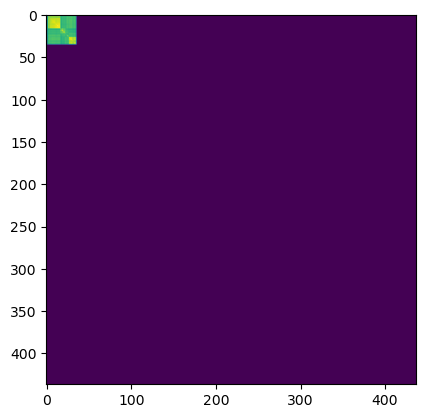

In [107]:
plt.imshow(C_lxl)

# simulated seq

In [108]:
arr_seq = readAlignment('data/cleaned_synthetic_serotonin_aligned.fasta')
print('len of sequences:', len(arr_seq))

# convert from array of string seq to numeric
arr_num = kim_helper.lett2num(arr_seq, code='ACDEFGHIKLMNPQRSTVWY-')
print('arr_num shape:', arr_num.shape)

hd = np.arange(0, len(arr_num))
print('seq shape before filtering:', arr_num.shape)
hFilt, seqFilt = kim_helper.filterAln(hd, arr_num)
print('seq shape after filtering:', seqFilt.shape)

# compute the one-hot encoding again
one_hot_filtered = kim_helper.alg2bin(seqFilt)
print('one hot after filtering:', one_hot_filtered.shape)

# compute the sequence identity matrix
n_align_pos = seqFilt.shape[1] # seqFilt.shape = (num_seq, num_positions)
identity_mpnn = kim_helper.simMat(one_hot_filtered, n_align_pos)
print('identity shape:', identity_mpnn.shape)

len of sequences: 100
arr_num shape: (100, 399)
seq shape before filtering: (100, 399)
seq shape after filtering: (100, 389)
one hot after filtering: (100, 8169)
identity shape: (100, 100)


one hot after filtering: (100, 8169)
(100, 100)


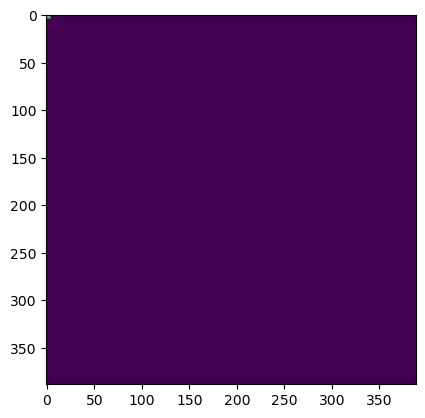

In [109]:
print('one hot after filtering:', one_hot_filtered.shape)
one_hot_filtered_np = one_hot_filtered.toarray()
L = int(one_hot_filtered_np.shape[1] / 21)
C_lxl = compute_lxl_cov(one_hot_filtered_np, L)

plt.imshow(C_lxl)

(array([[384.,   0.,   0., ...,   0.,   0.,   1.],
        [384.,   0.,   0., ...,   1.,   0.,   1.],
        [384.,   0.,   0., ...,   1.,   0.,   1.],
        ...,
        [389.,   0.,   0., ...,   0.,   0.,   0.],
        [389.,   0.,   0., ...,   0.,   0.,   0.],
        [389.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([  0.        ,  23.07943445,  46.15886889,  69.23830334,
         92.31773779, 115.39717224, 138.47660668, 161.55604113,
        184.63547558, 207.71491003, 230.79434447]),
 <a list of 389 BarContainer objects>)

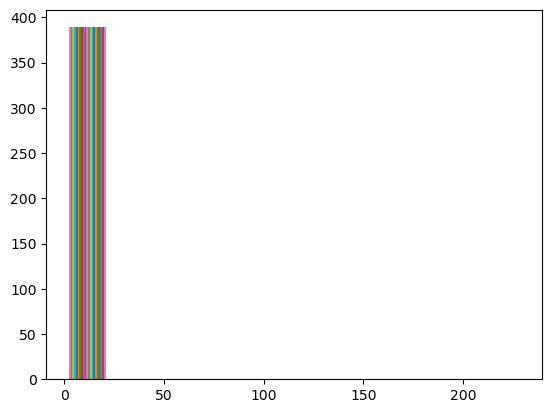

In [110]:
plt.hist(C_lxl)

In [111]:
C_lxl.shape

(389, 389)

In [112]:
C_lxl

array([[230.79434447, 151.81233933, 126.40359897, ...,   0.        ,
          0.        ,   0.        ],
       [151.81233933, 207.92030848, 173.18251928, ...,   0.        ,
          0.        ,   0.        ],
       [126.40359897, 173.18251928, 227.62724936, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])